<a href="https://colab.research.google.com/github/MasoudMoeini/Google-Street-View-Images-Blur-Detection/blob/main/VGG_SBDN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras,os
import cv2
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model,load_model
from keras import layers
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
!unzip -qq images.zip

replace images/0-4695.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!unzip -qq labels.zip

In [ ]:
from numpy import *
images_folder= "images/*.jpg"
labels_folder = "labels/"
def data_preprocessing(images_folder,labels_folder):
  total_img = []
  class_label=[]
  label = []
  files = glob.glob (images_folder)
  for myFile in files[:4000]:
      image_name=os.path.split(myFile)[1]
      class_label.append(float(image_name[0]))
      image = array(Image.open(myFile))
      label_image = array(Image.open(labels_folder+image_name))
      label.append (label_image)
      total_img.append (image)
  total_img = np.array(total_img)
  label = np.array(label)
  class_label=np.array(class_label) 
  label= np.reshape(label,[label.shape[0],label.shape[1],label.shape[2],label.shape[3]])
  total_img= np.reshape(total_img,[total_img.shape[0],total_img.shape[1],total_img.shape[2],total_img.shape[3]])
  #np.save('class_labels', class_label)
  #np.save('total-images',total_img)
  #np.save('label-images',label)
  return class_label,label,total_img

In [ ]:
class_labels,total_labels,total_images=data_preprocessing(images_folder,labels_folder)

In [ ]:
total_images.shape

(4000, 224, 224, 3)

In [40]:
encoder_model = keras.Sequential(
    [
    keras.Input(shape=(224,224,3)),
    layers.Conv2D(64,(3,3),padding="same", activation="relu"),
    layers.Conv2D(64,(3,3),padding="same", activation="relu"),
    layers.MaxPool2D((2,2),strides=(2,2)),
    layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2),name="end_of_encoding"),
    ]
) 
encoder_model.summary()
#keras.utils.plot_model(encoder_model, show_shapes=True)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_73 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_74 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_75 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                

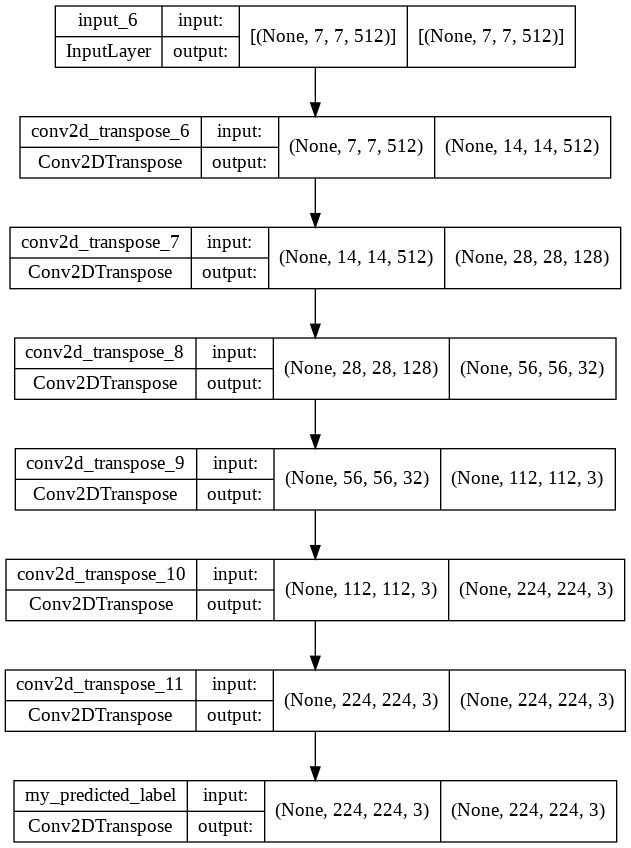

In [33]:
identifier_model = keras.Sequential(
    [
        keras.Input(shape=(7, 7,512)),
        #layers.Reshape([7,7,512]),
        layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same',activation="relu"),
        layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same',activation="relu"),
        layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same',activation="relu"),
        layers.Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same',activation="relu"),
        layers.Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same',activation="relu"),
        layers.Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same',activation="sigmoid"),
        layers.Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same',activation="sigmoid", name="my_predicted_label"),
    ]
    )
keras.utils.plot_model(identifier_model, show_shapes=True)

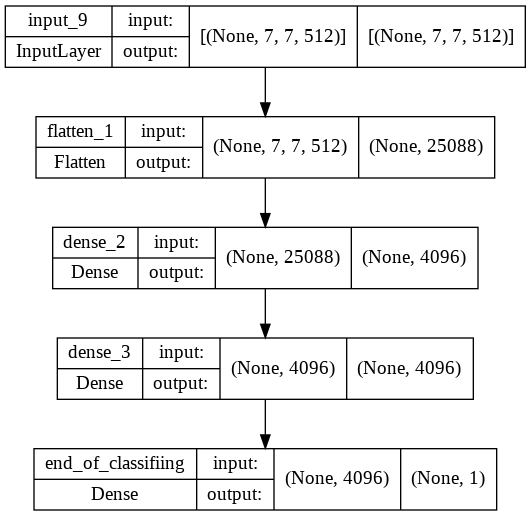

In [37]:
classifier_model = keras.Sequential([
    keras.Input(shape=(7, 7,512)),
    layers.Flatten(),
    layers.Dense(units=4096,activation="relu"),
    layers.Dense(units=4096,activation="relu"),
    layers.Dense(units=1, activation="sigmoid",name="end_of_classifiing"),
]
)
keras.utils.plot_model(classifier_model, show_shapes=True)  

In [ ]:
encoder_output=keras.Model(encoder_model.inputs, 
                           encoder_model.get_layer(name="end_of_encoding").output,name="encoder")
feature_extractor = keras.Model( identifier_model.inputs,
                                identifier_model.get_layer(name="my_predicted_label").output,name="identifier")
class_extractor = keras.Model( classifier_model.inputs,
     classifier_model.get_layer(name="end_of_classifiing").output,name="classifier")

In [ ]:
class_label=class_labels
x_train = total_images[:3000].astype(np.float32)/ 255.0
y_train=total_labels[:3000].astype(np.float32)/ 255.0
y_train = ( y_train,class_label)

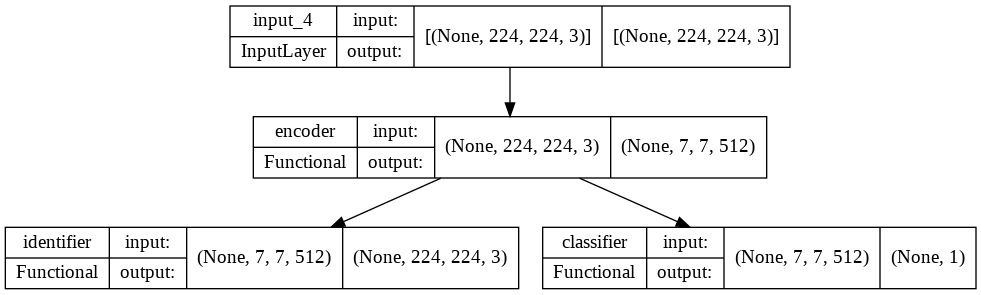

In [ ]:
vgg_input = keras.Input(shape=(224,224,3)),
encoded_img = encoder_output(vgg_input)
predicted_img = feature_extractor(encoded_img)
predicted_class_result = class_extractor(encoded_img)
vgg_SBDN_model = keras.Model(vgg_input,[predicted_img,predicted_class_result])
keras.utils.plot_model(vgg_SBDN_model, show_shapes=True)

In [ ]:
loss1=tf.keras.losses.MeanSquaredError()
loss2="binary_crossentropy"
vgg_SBDN_model.compile(keras.optimizers.Adam(learning_rate=1e-3),loss = [loss1,loss2],metrics=["accuracy"])

In [ ]:
history = vgg_SBDN_model.fit(x_train,[y_train[0],y_train[1]], epochs=5,batch_size=20, validation_split=0.2,shuffle=True)
#vgg_SBDN_model.save('vgg_model.h5')

Epoch 1/5
120/120 [==============================] - 64s 389ms/step - loss: 0.8790 - identifier_loss: 0.1095 - classifier_loss: 0.7694 - identifier_accuracy: 0.0000e+00 - classifier_accuracy: 0.5050 - val_loss: 0.7649 - val_identifier_loss: 0.0736 - val_classifier_loss: 0.6913 - val_identifier_accuracy: 0.0000e+00 - val_classifier_accuracy: 0.5383
Epoch 2/5
120/120 [==============================] - 45s 377ms/step - loss: 0.7695 - identifier_loss: 0.0765 - classifier_loss: 0.6930 - identifier_accuracy: 1.3951e-05 - classifier_accuracy: 0.5158 - val_loss: 0.7624 - val_identifier_loss: 0.0722 - val_classifier_loss: 0.6902 - val_identifier_accuracy: 1.9930e-05 - val_classifier_accuracy: 0.5383
Epoch 3/5
120/120 [==============================] - 46s 381ms/step - loss: 0.7690 - identifier_loss: 0.0760 - classifier_loss: 0.6931 - identifier_accuracy: 0.0023 - classifier_accuracy: 0.5158 - val_loss: 0.7632 - val_identifier_loss: 0.0720 - val_classifier_loss: 0.6913 - val_identifier_accuracy:

In [ ]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'identifier_loss', 'classifier_loss', 'identifier_accuracy', 'classifier_accuracy', 'val_loss', 'val_identifier_loss', 'val_classifier_loss', 'val_identifier_accuracy', 'val_classifier_accuracy'])


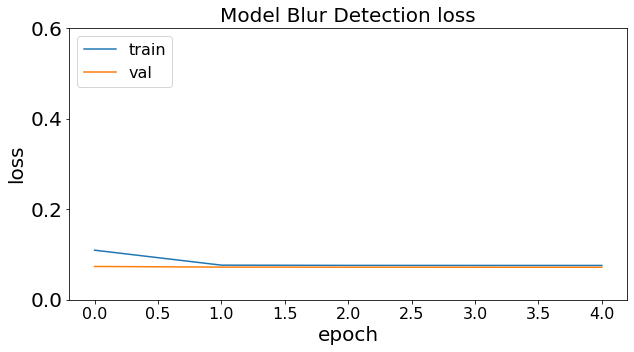

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['identifier_loss'])
plt.plot(history.history['val_identifier_loss'])
plt.title('Model Blur Detection loss',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.yticks(np.arange(0,0.8, 0.2),fontsize=20)
plt.xticks(fontsize=16)
plt.legend(['train', 'val'], loc='upper left',fontsize=16)
plt.show()

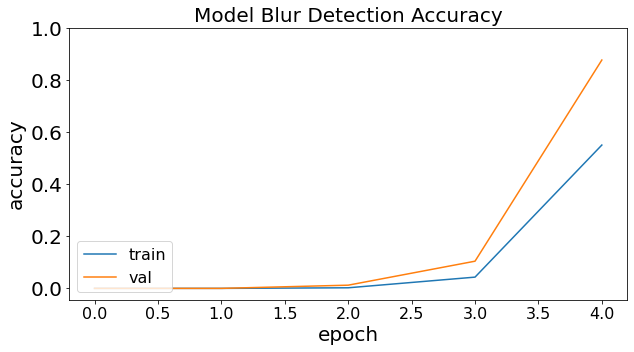

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['identifier_accuracy'])
plt.plot(history.history['val_identifier_accuracy'])
plt.title('Model Blur Detection Accuracy',fontsize=20)
plt.ylabel('accuracy',fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.yticks(np.arange(0,1.2,0.2),fontsize=20)
plt.xticks(fontsize=16)
plt.legend(['train', 'val'], loc='lower left',fontsize=16)
plt.show()

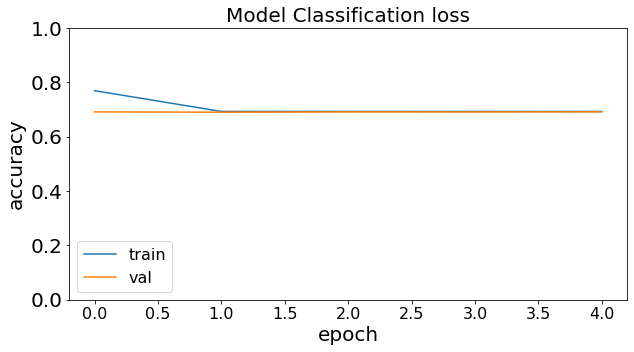

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['classifier_loss'])
plt.plot(history.history['val_classifier_loss'])
plt.title('Model Classification loss',fontsize=20)
plt.ylabel('accuracy',fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.yticks(np.arange(0,1.2,0.2),fontsize=20)
plt.xticks(fontsize=16)
plt.legend(['train', 'val'], loc='lower left',fontsize=16)
plt.show()

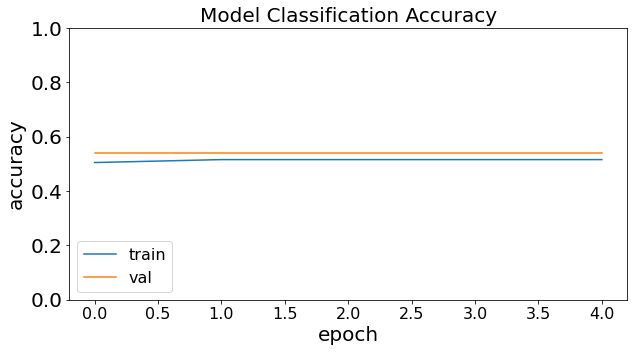

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['classifier_accuracy'])
plt.plot(history.history['val_classifier_accuracy'])
plt.title('Model Classification Accuracy',fontsize=20)
plt.ylabel('accuracy',fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.yticks(np.arange(0,1.2,0.2),fontsize=20)
plt.xticks(fontsize=16)
plt.legend(['train', 'val'], loc='lower left',fontsize=16)
plt.show()

In [ ]:
#evaluation images
eval_images=total_images[3000:]
eval_labels=total_labels[3000:]
eval_class_label=class_labels[3000:]

In [ ]:
from keras.models import load_model
from PIL import Image
images = eval_images
#model = load_model("vgg_model.h5")
predictions=[]
for i in range(images.shape[0]):
  img = images[i]
  img = img.astype(np.float32)/ 255.0
  img = np.expand_dims(img, -1)
  img = np.expand_dims(img, 0)
  pred = vgg_SBDN_model.predict(img)
  predictions.append(pred)

In [ ]:
y_pred_class=[]
for i in range(len(predictions)):
  predicted_class=(((predictions[i])[1])[0])[0]
  if (predicted_class>0.5):
    predicted_class=1.0
  else:
    predicted_class=0.0
  y_pred_class.append(predicted_class)
y_pred_class=np.array(y_pred_class)

Confusion Matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
conf_m = confusion_matrix(eval_class_label, y_pred_class)
conf_m

array([[  0, 498],
       [  0, 502]])

In [ ]:
report = classification_report(eval_class_label, y_pred_class)
print(report)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       498
         1.0       0.50      1.00      0.67       502

    accuracy                           0.50      1000
   macro avg       0.25      0.50      0.33      1000
weighted avg       0.25      0.50      0.34      1000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def get_iou_score(predictions,eval_labels):
  iou_scores=[]
  for i in range(len(predictions)):
    true_label = eval_labels[i]/255.0
    y_pred_label = np.where((((predictions[i])[0])[0])>0.5,1.0,0.0)
    #y_pred_label= ((((predictions[i])[0])[0])*255.0).astype(np.uint8)
    #iou = true_positives / (true_positives + false_positives + false_negatives)
    m = tf.keras.metrics.MeanIoU(num_classes=2)
    m.update_state(true_label, y_pred_label)
    iou_scores.append(m.result().numpy())
    #intersection = np.logical_and(true_label, y_pred_label)
    #union = np.logical_or(true_label, y_pred_label)
    #iou_score = np.sum(intersection) / np.sum(union)
    #iou_scores.append(iou_score)
  return mean(iou_scores)

In [ ]:
iou_score = get_iou_score(predictions,eval_labels)

In [ ]:
print('Average Intersection over Union IoU for Blur Detection: ',iou_score )

Average Intersection over Union IoU for Blur Detection:  0.7117123


predicted class vs true class


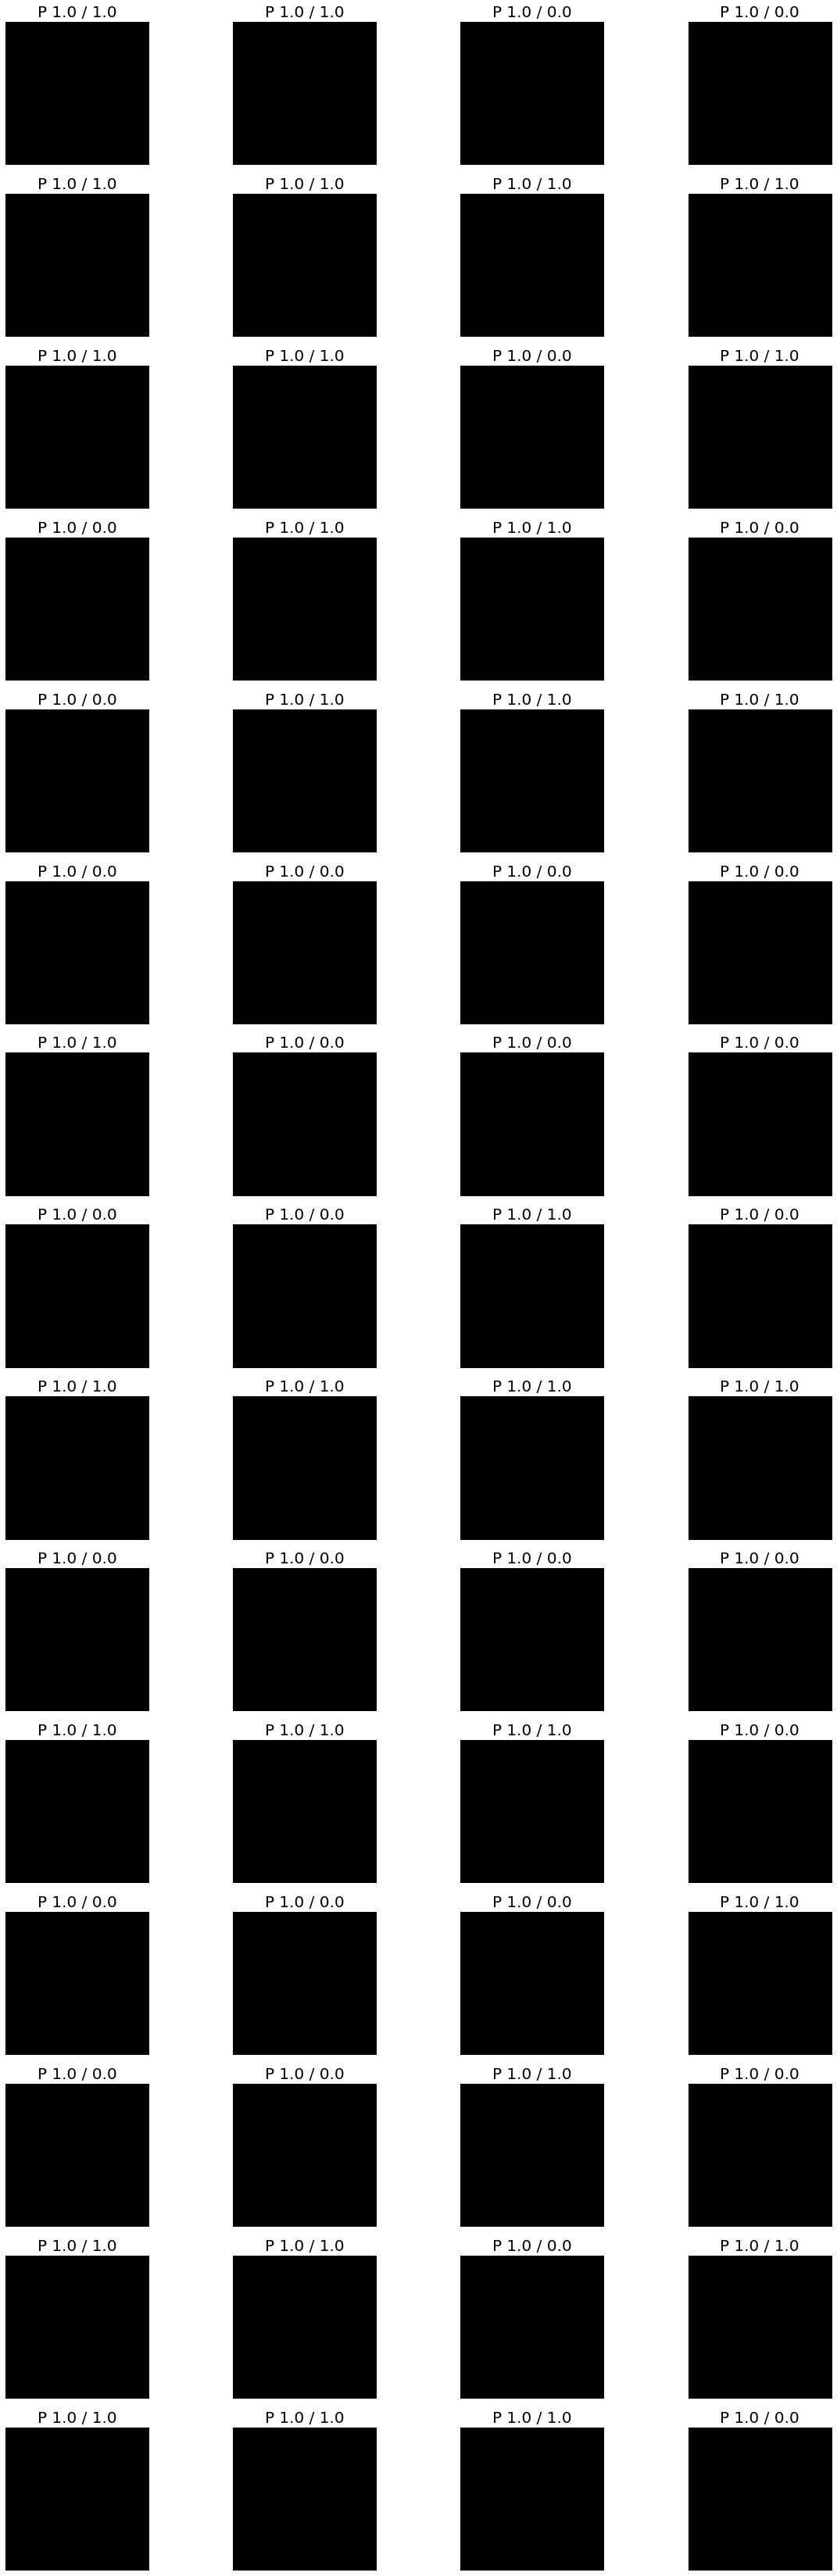

In [31]:
columns = 4
rows = 15
print("predicted class vs true class")
fig = plt.figure(figsize=(20,60))
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  img_pred_label = np.where((((predictions[i])[0])[0])>0.5,1.0,0.0)
  plt.imshow((img_pred_label*255.0).astype(np.uint8))
  predicted_class=(((predictions[i])[1])[0])[0]
  if (predicted_class>0.5):
    predicted_class=1.0
  else:
    predicted_class=0.0
  plt.title(f"P {predicted_class} / {eval_class_label[i]}",fontsize=20)
  plt.axis("off")
plt.show()

predicted class vs true class


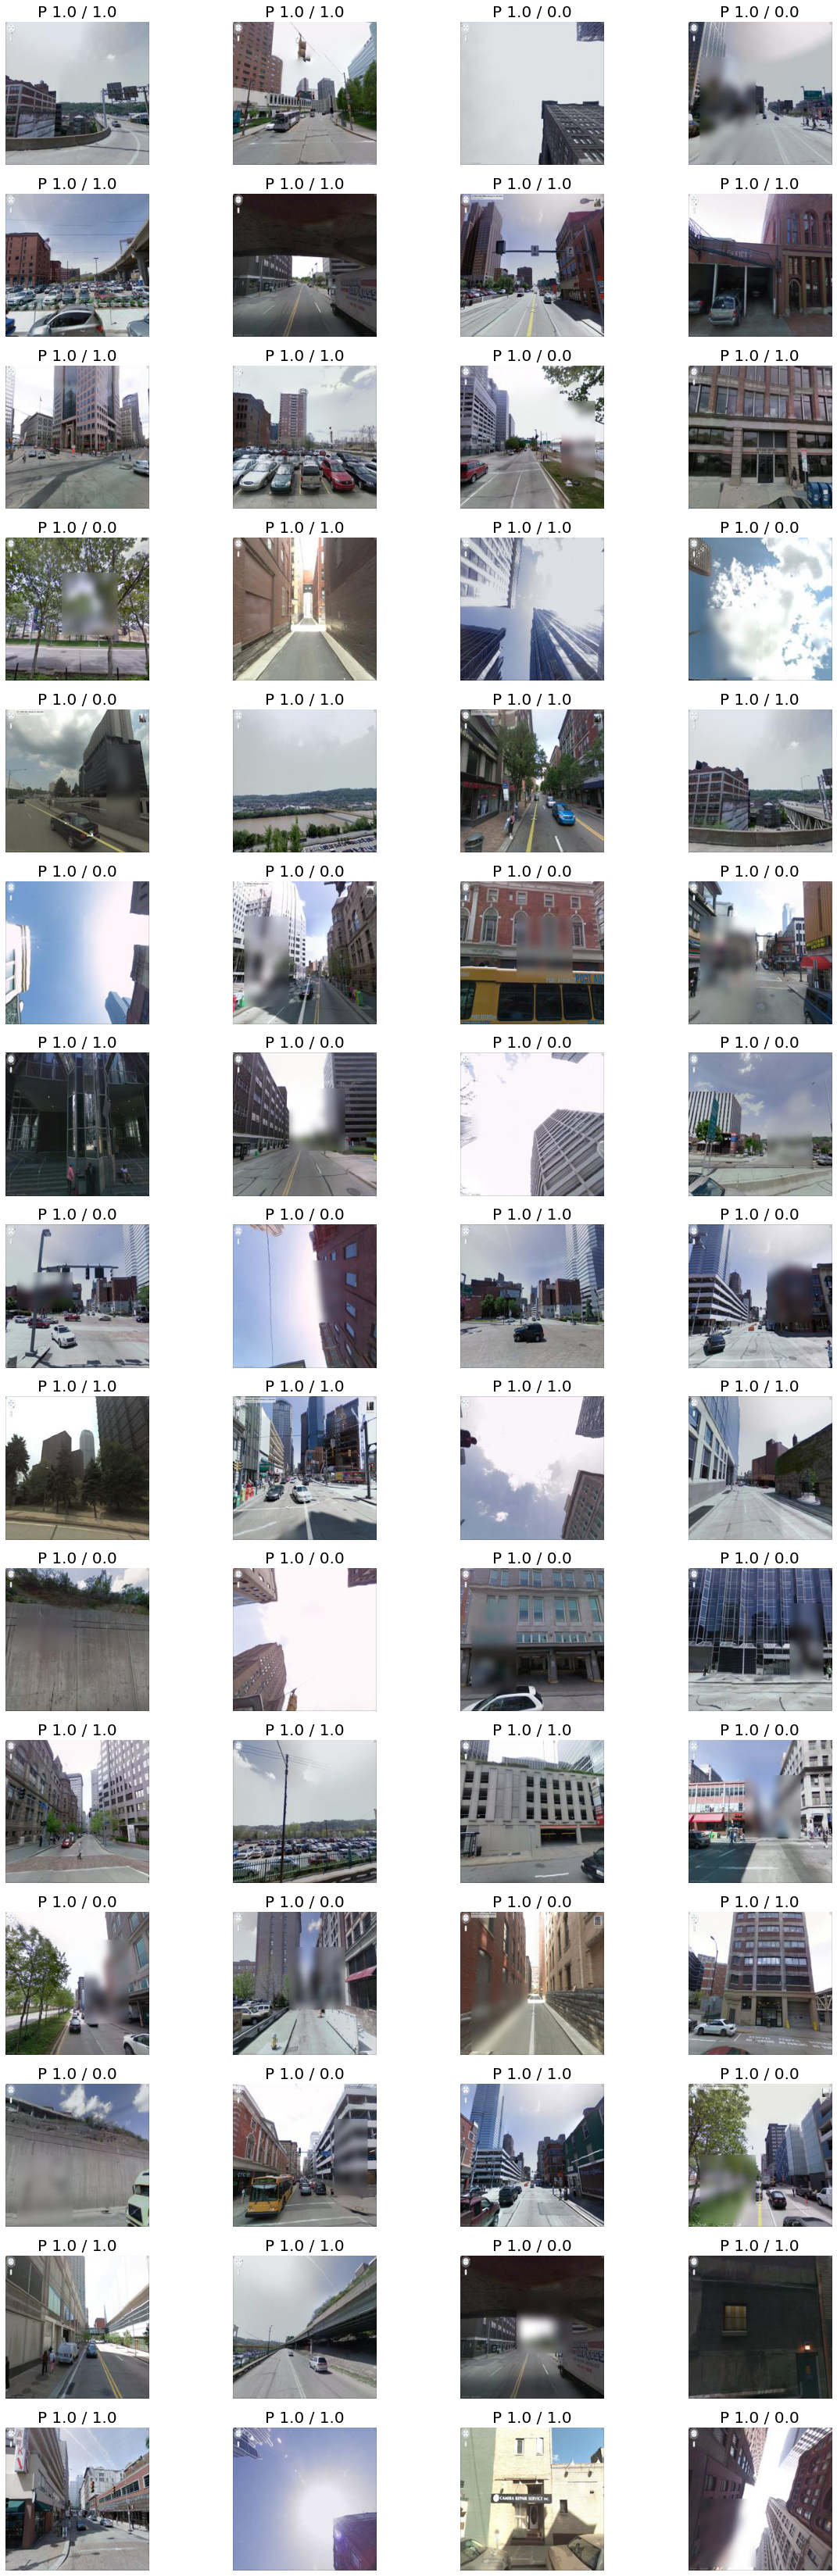

In [ ]:
fig = plt.figure(figsize=(20,60))
columns = 4
rows = 15
print("predicted class vs true class")
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  img_pred_label = np.where((((predictions[i])[0])[0])>0.5,1.0,0.0)
  mask=(img_pred_label*255.0).astype(np.uint8)
  blackFrame = np.zeros((224,224, 3), dtype = "uint8")
  whiteFrame = 255 * np.ones((224,224,3), np.uint8)
  #label_img = Image.fromarray(label_img)
  mask = np.where(mask==255,whiteFrame,blackFrame)
  img= images[i]
  cyan = np.full_like(img,(80, 229, 235))
  blend = 0.5
  img_cyan = cv2.addWeighted(img, blend, cyan, 1-blend, 0)
  mask = np.where(mask>=165,img_cyan,img)
  #mask =cv2.cvtColor(mask , cv2.COLOR_BGR2RGB)
  plt.imshow(mask,cmap='binary')
  #mask = Image.fromarray(mask)
  predicted_class=(((predictions[i])[1])[0])[0]
  if (predicted_class>0.5):
    predicted_class=1.0
  else:
    predicted_class=0.0
  plt.title(f"P {predicted_class} / {eval_class_label[i]}",fontsize=20)
  plt.axis("off")
plt.show()